In [143]:
import numpy as np
import requests
import pandas as pd
import json
import os
import glob
import matplotlib.pyplot as plt


token = 'm3lB5Q8zHn7wis2frICKXcmPb7yERygZnPypvcjuKPcye4IKkwdY'
base_url = 'https://api.lens.org/scholarly/search'


In [ ]:
df = pd.read_csv('/Users/jmccarty/GitHub/urban_bipv_annotated_bib/data/lens_bipv_general_cleaning.csv')
df = df[df['Remove']!=True]
lens_id_list = df['Lens ID'].values.tolist()

In [ ]:
lens_id_query_art = {
 "query": {
   "bool": {
     "must": [{
       "terms": {
         "lens_id": lens_id_list
       }},
       {"bool": {
         "must": [
           {"term": {"publication_type": "journal article"}},
         ]
       }
       }
     ]
   }
 }
}

lens_id_query_conf = {
 "query": {
   "bool": {
     "must": [{
       "terms": {
         "lens_id": lens_id_list
       }},
       {"bool": {
         "must": [
           {"term": {"publication_type": "conference proceedings"}},
         ]
       }
       }
     ]
   }
 }
}

In [ ]:
lens_id_query = {
     "query": {
           "terms":{
                "lens_id": lens_id_list
           }
     },
     "include":["lens_id","publication_type","year_published","title","abstract","authors.affiliations.name","languages"]
}

lens_id_query2 = {
           "terms":{
                "lens_id": lens_id_list
           }
     }

In [ ]:
headers = {'Authorization': token, 'Content-Type': 'application/json'}
response = requests.post(base_url, json=lens_id_query, headers=headers)
if response.status_code != requests.codes.ok:
    print(response.status_code)
else:
    json_data = json.loads(response.text)
    print(len(json_data['data']))
json_data['data'][2]

In [ ]:
import requests
import time
url = 'https://api.lens.org/scholarly/search'

# include fields
# field_list = ["lens_id","publication_type","year_published","title","abstract","authors.affiliations.name","languages"]

# request body with scroll time of 1 minute
request_body = {
     "query": lens_id_query2,
     "size": 1000,
     "scroll":"1m",
}
headers = {'Authorization': token, 'Content-Type': 'application/json'}

# Recursive function to scroll through paginated results
def scroll(scroll_id):
    # Change the request_body to prepare for next scroll api call
    # Make sure to append the include fields to make faster response
    if scroll_id is not None:
        global request_body
        request_body = {"scroll_id": scroll_id}

    # make api request
    response = requests.post(url, json=request_body, headers=headers) 

    # If rate-limited, wait for n seconds and proceed the same scroll id
    # Since scroll time is 1 minutes, it will give sufficient time to wait and proceed
    if response.status_code == requests.codes.too_many_requests:
        time.sleep(8)
        scroll(scroll_id)
    # If the response is not ok here, better to stop here and debug it
    elif response.status_code != requests.codes.ok:
        print(response.json())
    # If the response is ok, do something with the response, take the new scroll id and iterate
    else:
        json_data = response.json()
        scroll_id = json_data['scroll_id'] # Extract the new scroll id from response

        print('Saving')
        idnumber = json_data['data'][0]['lens_id']
        json.dump(json_data,open(f'/Users/jmccarty/Desktop/bipv_data/dump_{idnumber}.json','w'))

        scroll(scroll_id)

# start recursive scrolling
scrolled = scroll(scroll_id=None)


## Move to Compiling and Cleaning

In [132]:
# write function to grab data from a single entry

def get_data(data,field):
    try:
        if field=='authors':
            try:
                value = 'org_' + str(data[field][0]['affiliations'][0]['name'])
            except KeyError:
                id_type = data[field][0]['ids'][0]['type']
                id_value = data[field][0]['ids'][0]['value']
                value = str(id_type) + '_' + str(id_value)
        else:
            try:
                value = data[field]
            except KeyError:
                value = 'none'
    except KeyError:
        value = 'none'
    
    return value




def extract_fields(data):
    data_dict = dict()
    data_dict['lens_id'] = get_data(data,'lens_id')
    data_dict['document_type'] = get_data(data,'publication_type')
    data_dict['title'] = get_data(data,'title')
    data_dict['abstract'] = get_data(data,'abstract')
    data_dict['affiliation'] = get_data(data,'authors')
    data_dict['keywords'] = get_data(data,'fields_of_study')
    data_dict['keywords_count'] = len(get_data(data,'fields_of_study'))
    data_dict['language'] = get_data(data,'languages')[0]
    return data_dict


In [133]:
# create file list 
files = glob.glob("/Users/jmccarty/Desktop/bipv_data/*.json")

# write function to create dataframe for each file
def function(current_file):
    with open(current_file) as jsonFile:
        json_str = jsonFile.read()
        json_data = json.loads(json_str)
        data_list = []
        # get_data(data,'abstract')
        for i in list(range(0,len(json_data['data']))):
            data_list.append(extract_fields(json_data['data'][i]))

        return pd.DataFrame(data_list)



In [158]:
#extract and concat all data into one frame
df_list = []

for i in files:
    df_list.append(function(i))

all_data = pd.concat(df_list)
print(len(all_data))

6958


In [171]:
all_data.to_csv('/Users/jmccarty/GitHub/urban_bipv_annotated_bib/data/lit_dataset_all.csv')

4892


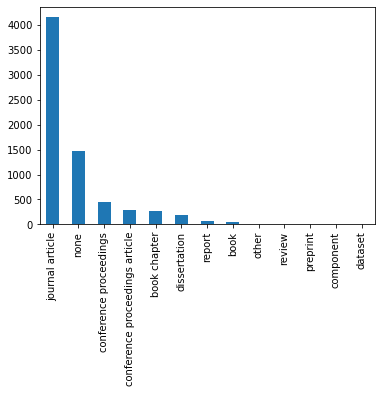

In [163]:
# check length after removing non peer review
pd.value_counts(all_data['document_type']).plot.bar()

all_data_peer = all_data[(all_data['document_type']=='journal article') | \
 (all_data['document_type']=='conference proceedings article') | \
  (all_data['document_type']=='conference proceedings')]

print(len(all_data_peer))

4662


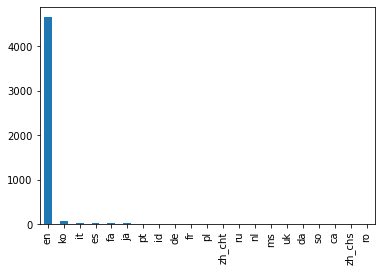

In [166]:
# check length after removing non english
pd.value_counts(all_data_peer['language']).plot.bar()

all_data_peer_en = all_data_peer[all_data_peer['language']=='en']

print(len(all_data_peer_en))

In [169]:
# check length after removing no abstract
# pd.value_counts(all_data_peer['language']).plot.bar()


all_data_peer_en_ab = all_data_peer_en[all_data_peer_en['abstract']!='none']
print(len(all_data_peer_en_ab))

4256


In [172]:
# save dataset to file
all_data_peer_en_ab.to_csv('/Users/jmccarty/GitHub/urban_bipv_annotated_bib/data/lit_dataset_clean.csv')